In [1]:
#%run 'word2vec_data.ipynb'
import cPickle as pickle
%pylab inline

import scipy
import numpy as np
import pandas as pd
#import plotly.plotly as py
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from gensim import models


import math
import codecs
import re
import string
from time import time


## Sklearn
from sklearn import svm, datasets
import sklearn

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import cross_validation, metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize, Imputer, OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, RandomTreesEmbedding
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import datasets, feature_selection, cluster, feature_extraction
from sklearn import neighbors, decomposition, metrics
from sklearn import cross_validation, grid_search, decomposition, feature_selection

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


from sklearn.pipeline import Pipeline, make_pipeline
from scipy import interp

#############################
### Matplotlib
import matplotlib.pyplot as plt # module for plotting 
from matplotlib import interactive, font_manager
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

#############################
### other stuff
from IPython import display

import os
#import ipyparallel as ipp
import warnings
warnings.filterwarnings('ignore')

# This is here to avoid all the Matplotlib warnings due to current bugs 
# - not a good idea to keep around
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

print ("Required Libraries loaded.")

Populating the interactive namespace from numpy and matplotlib
Required Libraries loaded.


In [2]:
inhibitor  = pd.read_csv("C:\EPC_Data\TREC_BROKEN\No_Mh_Tag/opiods_no_mh.csv", sep=",", index_col = "PMID")

In [3]:
folder = "C:\Users\CR107\Dropbox\PhD\Experiments\TREC_2004\data\word2vec"
filepath = os.path.join(folder, "opiods_1000features_10minwords_15context")
model = models.Word2Vec.load(filepath)
print (model["clinical"][:10])
print ("\nMatrix of word vectors is size : ", model.syn0.shape)

[ 0.05496166  0.05857657 -0.09459522 -0.01349878 -0.00286666 -0.05296639
 -0.0891526  -0.04481089  0.01484196 -0.00808054]
('\nMatrix of word vectors is size : ', (3900L, 1000L))


In [4]:
#Create feature vectors from the averages of word vectors

def makeFeatureVec(words, model):
    """
    words - list of words (i.e. article) to be used as input for the creation of word vectors
    model - model to use for the creation of the vectors
    
    makeFeatureVec: Function to average all of the word vectors in a given paragraph
    returns: a numpy array of floats that are the average of the constituent word vectors for each word
    """
    num_features = model.syn0.shape[1]
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index2word)
    #
    # Loop over each word in the article and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(articles, model):
    """
    articles - list of articles for which the creation of word vectors needs to be done for each
    model - model to use for the creation of the vectors
    
    getAvgFeatureVecs: Given a set of articles (each one a list of words), calculate 
    the average feature vector for each one and return a 2D numpy array 
    returns: a 2D numpy array that contains the average of the constituent word vectors for each article
    """
    num_features = model.syn0.shape[1]
    articleFeatureVecs = np.zeros((len(articles),num_features),dtype="float32")
    counter = 0.
    
    # Loop through the articles
    for article in articles:
        #
        # Print a status message every 1000th review
        if counter%500. == 0.:
            print ("Article %d of %d" % (counter, len(articles)))
        # 
        # Call the function (defined above) that makes average feature vectors
        articleFeatureVecs[counter] = makeFeatureVec(article, model)
        #
        # Increment the counter
        counter = counter + 1.
    return articleFeatureVecs

In [5]:
# Import articles for string cleaning

def clean_text(text, stem_words = False, remove_stopwords = False):
    ###clean
    texts = re.sub("[^a-zA-Z]",    #pattern to match
              " ",              #replace other with this
              str(text))                 #text to apply to
         
    #print "Text recived: ", texts 
    clean_corpus = texts.lower().split()
    #print "corpus: ", clean_corpus
    if stem_words:
        # Porter stemmer
        porter = nltk.PorterStemmer()
        # Snowball stemmer
        snowball = nltk.SnowballStemmer('english')
        # Lancaster stemmer
        lancaster = nltk.LancasterStemmer()
        # General stemming Lambda function to stem tokens
        clean_corpus = lambda tokens: [porter.stem(w) for w in corpus]
    if remove_stopwords:   # Optionally remove stop words
        stops = set(stopwords.words("english"))
        clean_corpus = [w for w in clean_corpus if not w in stops]
        #print "Clean_corpus: ", clean_corpus
    
    return (clean_corpus)

In [6]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. We remove stopwords.

print ("Creating average feature vecs for articles")
cleaned_articles = []
for article in inhibitor.TIABSMh:
    cleaned_articles.append(clean_text(article, stem_words=False, remove_stopwords=True ))

averageWordVecs = getAvgFeatureVecs(cleaned_articles, model)

Creating average feature vecs for articles
Article 0 of 1883
Article 500 of 1883
Article 1000 of 1883
Article 1500 of 1883


In [7]:
pd.isnull(pd.DataFrame(averageWordVecs)).any(1).nonzero()[0]

array([], dtype=int64)

In [8]:
print (np.isnan(averageWordVecs).any())
print (len(averageWordVecs[np.isnan(averageWordVecs)]))
averageWordVecs[np.isnan(averageWordVecs)]
averageWordVecs[np.isnan(averageWordVecs)].shape

False
0


(0L,)

In [9]:
for art in inhibitor.TIABSMh[:2]:
    print (getAvgFeatureVecs(clean_text(art, stem_words=False, remove_stopwords=True ), model))

Article 0 of 77
[[  2.72987015e-03   1.74180474e-02   2.00589728e-02 ...,  -1.91659313e-02
    3.42380144e-02   1.01507828e-02]
 [ -1.05753709e-02   1.48115801e-02   4.17416617e-02 ...,   2.03835801e-03
    3.84658985e-02   4.27234918e-05]
 [  1.11820176e-03  -3.58799472e-04   3.70919406e-02 ...,  -2.96658818e-02
    2.73992382e-02  -5.63590135e-03]
 ..., 
 [ -6.61982503e-03   1.99433952e-03   3.51337381e-02 ...,  -2.39201728e-02
    3.32884714e-02  -6.84700673e-03]
 [ -9.07422323e-03  -8.00582673e-03   3.36929150e-02 ...,  -1.91913079e-02
    3.82375196e-02   6.17906544e-03]
 [ -2.85662413e-02  -1.39823956e-02   3.44487503e-02 ...,  -1.46389902e-02
    2.91134622e-02   7.22682988e-03]]
Article 0 of 153
[[  2.72987015e-03   1.74180474e-02   2.00589728e-02 ...,  -1.91659313e-02
    3.42380144e-02   1.01507828e-02]
 [ -1.05753709e-02   1.48115801e-02   4.17416617e-02 ...,   2.03835801e-03
    3.84658985e-02   4.27234918e-05]
 [  1.11820176e-03  -3.58799472e-04   3.70919406e-02 ...,  -2.9

In [10]:
pd.DataFrame(averageWordVecs).head(5)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.016530,0.037194,-0.033557,-0.003867,-0.013984,-0.010608,-0.021266,-0.012034,0.009679,-0.004499,...,0.004178,-0.008394,0.004817,0.018336,-0.000500,-0.012749,-0.024940,0.004312,-0.003595,0.018145
1,0.026094,0.049667,-0.045100,-0.000043,-0.015914,-0.021477,-0.043414,-0.024250,0.007199,0.006368,...,0.010889,-0.017968,0.027618,0.035127,-0.003584,-0.000259,-0.038859,0.012650,-0.004471,0.009913
2,0.017033,0.038753,-0.018915,0.006580,-0.018576,-0.010096,-0.027298,-0.007747,0.006568,0.001239,...,0.022654,-0.007264,0.006857,0.033423,-0.005127,-0.007061,-0.014139,0.009260,0.000689,0.007952
3,0.017373,0.033182,-0.004103,0.006134,-0.009587,0.001459,-0.016762,-0.009933,0.004853,0.004044,...,0.020509,-0.003076,0.014414,0.024604,0.001749,0.009610,-0.017160,0.010407,0.004255,0.002150
4,0.023502,0.043335,-0.025490,0.005739,-0.012823,-0.014762,-0.034908,-0.016176,0.003705,0.003144,...,0.016682,-0.014765,0.017439,0.035780,-0.002655,-0.003404,-0.024920,0.016420,-0.004117,0.002794


In [11]:
RANDOM_STATE = 55
TEST_SIZE = 0.4

X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

print (len(X_train))
print (len(X_test))

1129
754


In [12]:
def weight(x):
    x = np.where(x==0, 1, 4)
    return x 

In [13]:
##  based on this SciKitLearn example:
# http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

# options
print_report = True
print_cm = True
print_top10 = True
n_features = 2 ** 16
filtered = True

########
# Load some categories from the training set

RANDOM_STATE = 55
TEST_SIZE = 0.4

X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)
sw_train = weight(y_train)
sw_test = weight(y_test)

categories = ['Irrelevant', 'Relevant']
print('Training and test datasets created')

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


########
# Benchmark the classifiers, one at a time
def benchmark(clf, name):
    """
    clf - the classifier
    name - its name
    
    benchmark: to create the benchmark metrics for the classification
    returns: the inputs to the results list
    """
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    try:
        clf.fit(X_train, y_train, sample_weight = sw_train)#no weight
    except:
        clf.fit(X_train, y_train)#no weight
        
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    acc_score = metrics.accuracy_score(y_test, pred, sample_weight = sw_test)
    print("accuracy:   %0.3f" % acc_score)
    
    prec_score = metrics.precision_score(y_test, pred, sample_weight=sw_test)
    print("precision:  %0.3f" % prec_score)
    
    recall = metrics.recall_score(y_test, pred, sample_weight=sw_test)
    print("recall:     %0.3f" % recall)
    
    # get the decision boundary or the probas.
    if hasattr(clf, "decision_function"):
        y_score = np.array(clf.decision_function(X_test))
    else:
        y_score = clf.predict_proba(X_test)[:,1]

    auc_score = metrics.roc_auc_score(y_test, y_score, sample_weight=sw_test)
    print("*** AUC for ROC = %0.3f\n" % auc_score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))
    #    print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                           target_names=categories, sample_weight = sw_test))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return name, acc_score, auc_score, prec_score, recall, train_time, test_time

def create_results():
    """
    create_results: to run the classification and create the of results 
    from the battery of classifiers
    returns: an multiD list of results
    """
    results = []
    for clf, name in (
            (RidgeClassifier(tol=1e-2, solver="lsqr", random_state=RANDOM_STATE, class_weight = 'balanced'), "Ridge Classifier"),
            (Perceptron(n_iter=1, random_state=RANDOM_STATE, class_weight = 'balanced'), "Perceptron"),
            (linear_model.LogisticRegression(C=1e2, random_state=RANDOM_STATE, class_weight = 'balanced'), "Logistic Regression 1e2"),
            (linear_model.LogisticRegression(C=1e6, random_state=RANDOM_STATE, class_weight = 'balanced'), "Logistic Regression 1e6"),
            (LinearSVC(penalty="l2", random_state=RANDOM_STATE, class_weight = 'balanced'), "Linear SVC L2 penalty"), 
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight = 'balanced'), "SVM with RBF kernel C=100"),
            (SGDClassifier(loss="hinge", penalty="l2", random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD classifier - hinge loss"),
            (SGDClassifier(loss="log", penalty="l2", random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD classifier - log loss"),
            (PassiveAggressiveClassifier(n_iter=1, random_state=RANDOM_STATE, class_weight = 'balanced'), "Passive-Aggressive"),
            (DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE, class_weight = 'balanced'), "Decision Tree MaxDepth=3"),
            (BaggingClassifier(n_estimators=40, max_samples=1.0, max_features=0.4, random_state=RANDOM_STATE), "Bagging 40 trees 40% max features"),
            (GradientBoostingClassifier(n_estimators=40, learning_rate=1.0, max_depth=1, random_state=RANDOM_STATE) , "GBT Classifier"),
            (GradientBoostingClassifier(n_estimators=40, learning_rate=0.7, max_depth=10, random_state=RANDOM_STATE), "GBT Classifier 0.7 -10"),
            ):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))

    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                                dual=False, tol=1e-3, random_state=RANDOM_STATE, class_weight = 'balanced'), "Linear SVC %s penalty" %penalty))


        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD classifier %s penalty" %penalty))
        results.append(benchmark(SGDClassifier(loss="hinge", alpha=.0001, n_iter=50,
                                       penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD hinge loss %s penalty" %penalty))
        results.append(benchmark(SGDClassifier(loss="log", alpha=.0001, n_iter=50,
                                   penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD log loss %s penalty" %penalty))
    return results

def comparison_plots(results):
    """
    results - array containing the results from the classification to plot
    
    yields: prints out the results from each classifier and then finishes with plots of the 
    accuracy scores and ROC AUC scores for all the classifiers
    """
    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet", random_state=RANDOM_STATE, class_weight = 'balanced'),"Elastic-Net penalty"))

    # Train sparse Naive Bayes classifiers
    #print('=' * 80)
    #print("Naive Bayes")
    #results.append(benchmark(MultinomialNB(alpha=.01),"Multinomial Naive Bayes"))
    #results.append(benchmark(BernoulliNB(alpha=.01),"Bernouilli Naive Bayes"))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    results.append(benchmark(Pipeline([
      ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3, random_state=RANDOM_STATE, class_weight = 'balanced')),
      ('classification', LinearSVC())
                ]),"LinearSVC - L1 feature selection"))

    ######
    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(7)]

    clf_names, acc_score, auc_score, prec_score, recall, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    ######
    #  Make a plot for the accuracy scores 
    plt.figure(figsize=(12, 8))
    plt.title("Accuracy Score")
    plt.barh(indices, acc_score, .2, label="accuracy score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    
    ######
    #  Make a plot for the ROC curve AUC scores 
    plt.figure(figsize=(12, 8))
    plt.title("ROC curve AUC Score")
    plt.barh(indices, auc_score, .2, label="AUC score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()
    

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()

Training and test datasets created


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=55, solver='lsqr', tol=0.01)
train time: 0.744s
test time:  0.005s
accuracy:   0.488
precision:  0.030
recall:     1.000
*** AUC for ROC = 0.965

classification report:
             precision    recall  f1-score   support

 Irrelevant       1.00      0.48      0.65     751.0
   Relevant       0.03      1.00      0.06      12.0

avg / total       0.98      0.49      0.64     763.0

confusion matrix:
[[360 391]
 [  0   3]]
()
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=1, n_jobs=1, penalty=None,
      random_state=55, shuffle=True, verbose=0, warm_start=False)
train time: 0.011s
test time

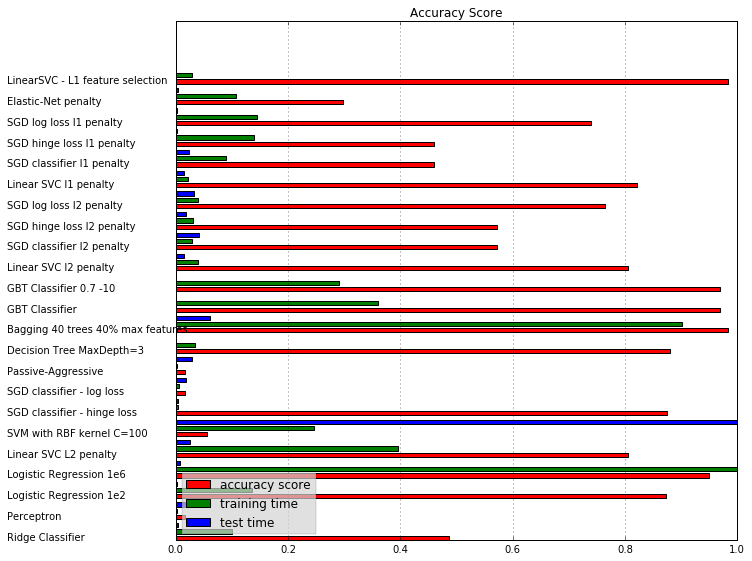

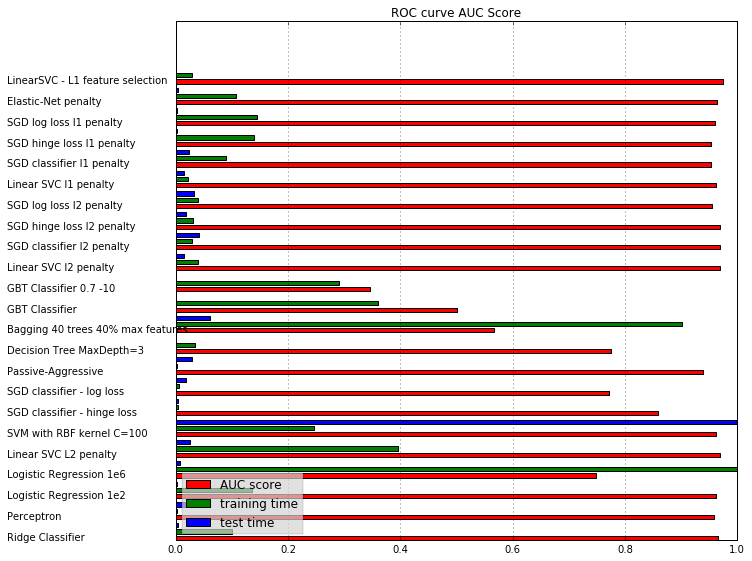

In [14]:
# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())

In [15]:
# Function to compute ROC curve and ROC area for each class
# based on the example in SciKitLearn
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def plot_ROC_curve(y_test, y_score):
    """
    y_test - truth series, single array
    y_score - prediction series, single array
    
    yields: plot of curve
    The function will plot the ROC curve and an embedded legend with the AUC score.
    """
    sw_test = weight(y_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=sw_test)
    roc_auc = auc(fpr, tpr)
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0:0.3f})' .format(roc_auc), linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

# Compute Precision-Recall and plot curve
# As above, based on the SciKit Learn example

def plot_PR_curve(y_test, y_score):
    """
    y_test - truth series, single array
    y_score - prediction series, single array
    
    yields: plot of curve
    The function will plot the precision recall curve and an embedded legend with the AUC score.
    """
    sw_test = weight(y_test)
    
    precision = dict()
    recall = dict()
    precision, recall, _ = precision_recall_curve(y_test, y_score, pos_label=1, sample_weight=sw_test)
    
    # Plot Precision-Recall curve for each class
    plt.clf()
    plt.plot(recall, precision, label='Precision-recall curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")
    plt.show()

# Convenience function to adjust plot parameters for a clear layout.
target_names = ["Excluded", "Included"]

def show_confusion_matrix(cm):
    """
    cm - confusion matrix parameters as output from confusion_matrix() function
    
    yields: a plot of the confusion matrix with imshow
    Convenience function to adjust confusion matrix plot parameters for a clear layout.
    """
    sw_test = weight(y_test)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_stats(clf, x_train, x_test, y_train, y_test):
    """
    clf - classifier
    x_train - matrix of training features
    x_test - matrix of training features
    y_train - array of training labels
    y_test - array of validation truths
    yields: print outs of the full suite of metrics for the classification for both training and validation sets
    """
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)

    print("Number of mislabeled points out of a total %d training points : %d"
          % (x_train.shape[0],(y_train != y_pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the training set: ", clf.score(x_train, y_train)), '\n')
    scores1 = cross_val_score(clf, x_train, y_train, cv=2, scoring = 'accuracy' , n_jobs = 1)
    scores2 = cross_val_score(clf, x_train, y_train, cv=2, scoring = 'f1' , n_jobs = 1)
    report = precision_recall_fscore_support(y_train, y_pred, average='macro')
    acc_score = accuracy_score(y_train, y_pred)#, sample_weight=sw_test)
    cm = confusion_matrix(y_pred, y_train)

    print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], report[2], acc_score))
    print("\n10-fold CV mean accuracy = %0.3f, mean F1 = %0.3f\n" % 
          (scores1.mean(), scores2.mean()))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the training set: \n",pd.DataFrame(cm) )
    show_confusion_matrix(cm)

    pred = clf.predict(x_test)

    print("Number of mislabeled points out of a total %d testing points : %d"
          % (x_test.shape[0],(y_test != pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the testing set: ", clf.score(x_test, y_test)), '\n')
    report = precision_recall_fscore_support(y_test, pred, average='macro')
    acc_score = accuracy_score(y_test, pred)
    cm = confusion_matrix(pred, y_test)

    print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], report[2], acc_score))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the testing set: \n",pd.DataFrame(cm))
    show_confusion_matrix(cm)

#### A function for running the classifier and generating the performance measures and plots

It will allow us to print out the accuracy scores, the confusion matrix and to plot the ROC and PR curves with the calculated AUC scores.


In [16]:
RANDOM_STATE = 55
TEST_SIZE = 0.4

def run_class(X, y, TEST_SIZE):
    """
    X - input matrix of features for the classification
    y - array of truths for the classification 
    TEST_SIZE - number or proportion to use for the test set - int is number, float is precentage
    
    yields: this version runs a battery of classifiers. For each of them, it  
    prints out the performance metrics for the classification and plots the ROC and PR curves
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)    
    
    sw_test = weight(y_test)
    
    for clf, name in (
            (RidgeClassifier(tol=1e-2, solver="lsqr", random_state=RANDOM_STATE), "Ridge Classifier"),
            (Perceptron(n_iter=1, random_state=RANDOM_STATE, class_weight = 'balanced'), "Perceptron"),
            (linear_model.LogisticRegression(C=1e2, random_state=RANDOM_STATE, class_weight = 'balanced'), "Logistic Regression 1e2"),
            (linear_model.LogisticRegression(C=1e6, random_state=RANDOM_STATE, class_weight = 'balanced'), "Logistic Regression 1e6"),
            (LinearSVC(penalty="l2", random_state=RANDOM_STATE, class_weight = 'balanced'), "Linear SVC L2 penalty"), 
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight = 'balanced'), "SVM with RBF kernel C=100"),
            (SGDClassifier(loss="hinge", penalty="l2", random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD classifier - hinge loss"),
            (SGDClassifier(loss="log", penalty="l2", random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD classifier - log loss"),
            (PassiveAggressiveClassifier(n_iter=1, random_state=RANDOM_STATE, class_weight = 'balanced'), "Passive-Aggressive"),
            (GradientBoostingClassifier(n_estimators=40, learning_rate=1.0, max_depth=1, random_state=RANDOM_STATE) , "GBT Classifier"),
            (GradientBoostingClassifier(n_estimators=40, learning_rate=0.7, max_depth=10, random_state=RANDOM_STATE), "GBT Classifier 0.7 -10"),
            (AdaBoostClassifier(n_estimators=10, random_state=RANDOM_STATE), "AdaBoost 10 trees"),
            (AdaBoostClassifier(n_estimators=40, random_state=RANDOM_STATE), "AdaBoost 40 trees")):
        
        print("\n", name, "\ntest size is %d %%  " % (TEST_SIZE*100))

        clf.fit(X_train, y_train)
        print (clf.score(X_test, y_test))
        
        mean_acc_score = clf.score(X_test, y_test)
        pred = clf.predict(X_test)

        report = precision_recall_fscore_support(y_test, pred, average='binary', sample_weight=sw_test)
        acc_score = accuracy_score(y_test, pred)
        cm = confusion_matrix(pred, y_test)

        # get the decision boundary or the probas.
        if hasattr(clf, "decision_function"):
            y_score = np.array(clf.decision_function(X_test))
        else:
            y_score = clf.predict_proba(X_test)[:,1]

        auc_score = metrics.roc_auc_score(y_test, y_score, sample_weight=sw_test)

        #print("mean_accuracy = %0.3f" % mean_acc_score)
        print("precision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f" % 
              (report[0], report[1], report[2], acc_score))
        print("The confusion matrix on the testing set:          \n", pd.DataFrame(cm))
        print("*********** AUC for ROC = %0.3f" % auc_score)
                
        plot_ROC_curve(y_test, y_score)
        plot_PR_curve(y_test, y_score)
        #print (y_score[:,:30])

('\n', 'Ridge Classifier', '\ntest size is 40 %  ')
0.996021220159
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.996
('The confusion matrix on the testing set:          \n',      0  1
0  751  3
1    0  0)
*********** AUC for ROC = 0.965


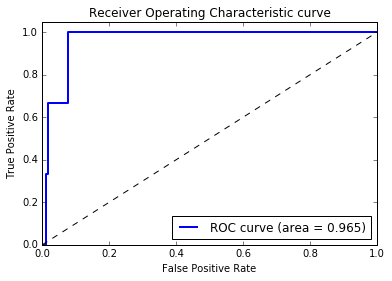

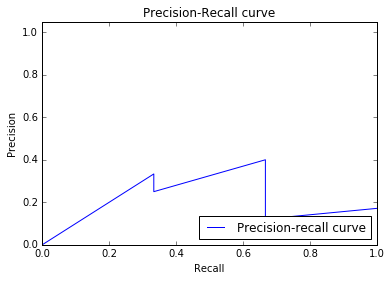

('\n', 'Perceptron', '\ntest size is 40 %  ')
0.00397877984085
precision = 0.016, recall = 1.000, F1 = 0.031, accuracy = 0.004
('The confusion matrix on the testing set:          \n',      0  1
0    0  0
1  751  3)
*********** AUC for ROC = 0.982


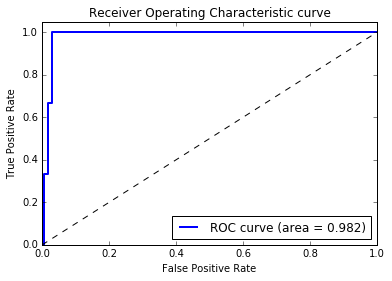

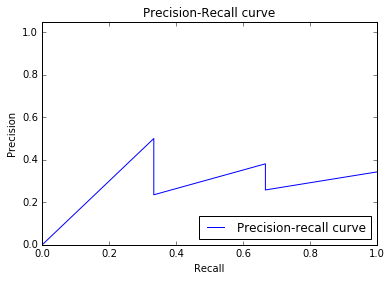

('\n', 'Logistic Regression 1e2', '\ntest size is 40 %  ')
0.871352785146
precision = 0.110, recall = 1.000, F1 = 0.198, accuracy = 0.871
('The confusion matrix on the testing set:          \n',      0  1
0  654  0
1   97  3)
*********** AUC for ROC = 0.962


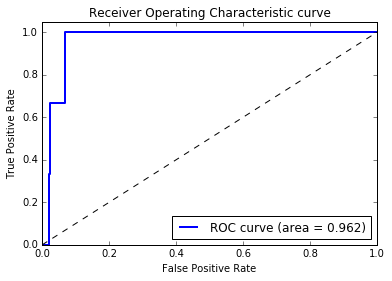

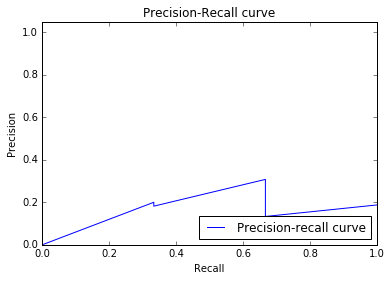

('\n', 'Logistic Regression 1e6', '\ntest size is 40 %  ')
0.957559681698
precision = 0.118, recall = 0.333, F1 = 0.174, accuracy = 0.958
('The confusion matrix on the testing set:          \n',      0  1
0  721  2
1   30  1)
*********** AUC for ROC = 0.748


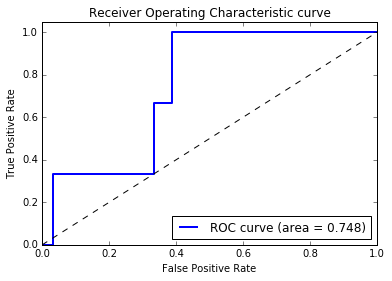

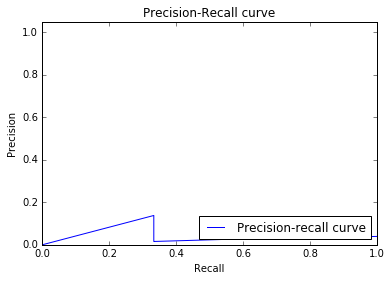

('\n', 'Linear SVC L2 penalty', '\ntest size is 40 %  ')
0.803713527851
precision = 0.075, recall = 1.000, F1 = 0.140, accuracy = 0.804
('The confusion matrix on the testing set:          \n',      0  1
0  603  0
1  148  3)
*********** AUC for ROC = 0.970


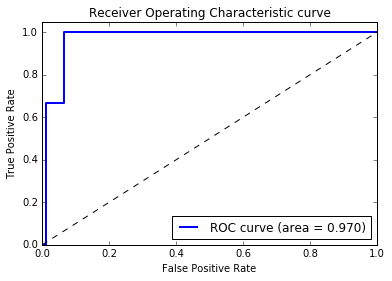

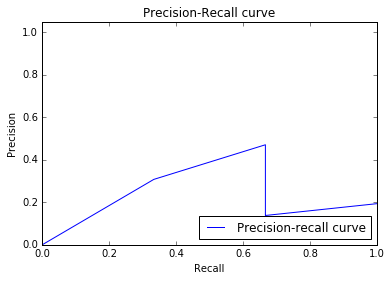

('\n', 'SVM with RBF kernel C=100', '\ntest size is 40 %  ')
0.57824933687
precision = 0.036, recall = 1.000, F1 = 0.070, accuracy = 0.578
('The confusion matrix on the testing set:          \n',      0  1
0  433  0
1  318  3)
*********** AUC for ROC = 0.968


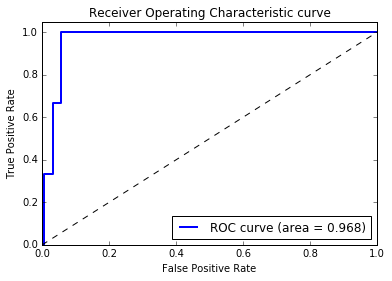

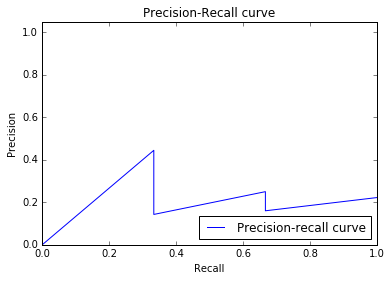

('\n', 'SGD classifier - hinge loss', '\ntest size is 40 %  ')
0.978779840849
precision = 0.348, recall = 0.667, F1 = 0.457, accuracy = 0.979
('The confusion matrix on the testing set:          \n',      0  1
0  736  1
1   15  2)
*********** AUC for ROC = 0.952


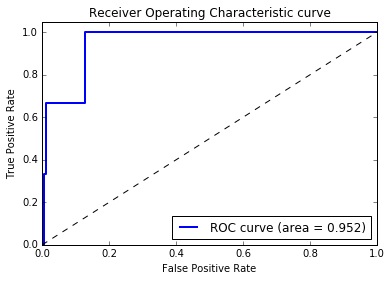

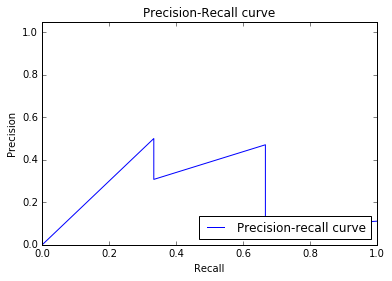

('\n', 'SGD classifier - log loss', '\ntest size is 40 %  ')
0.976127320955
precision = 0.320, recall = 0.667, F1 = 0.432, accuracy = 0.976
('The confusion matrix on the testing set:          \n',      0  1
0  734  1
1   17  2)
*********** AUC for ROC = 0.958


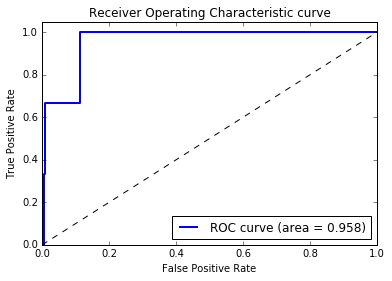

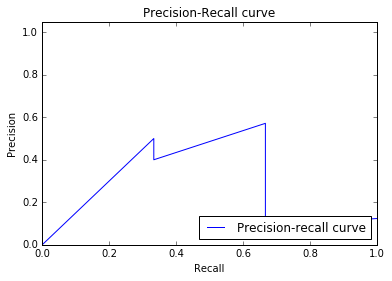

('\n', 'Passive-Aggressive', '\ntest size is 40 %  ')
0.00397877984085
precision = 0.016, recall = 1.000, F1 = 0.031, accuracy = 0.004
('The confusion matrix on the testing set:          \n',      0  1
0    0  0
1  751  3)
*********** AUC for ROC = 0.939


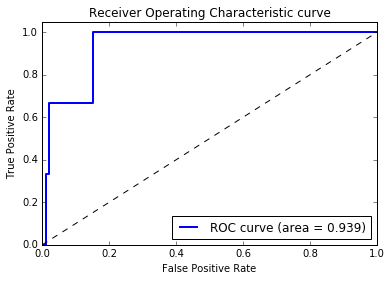

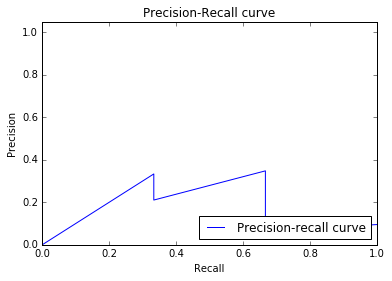

('\n', 'GBT Classifier', '\ntest size is 40 %  ')
0.993368700265
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.993
('The confusion matrix on the testing set:          \n',      0  1
0  749  3
1    2  0)
*********** AUC for ROC = 0.501


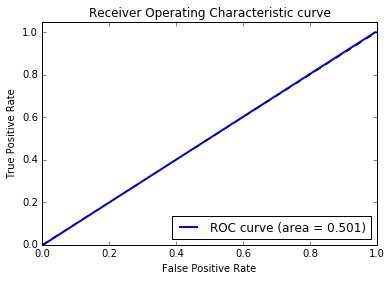

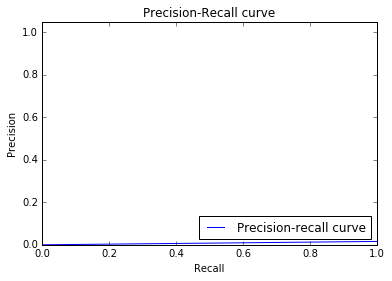

('\n', 'GBT Classifier 0.7 -10', '\ntest size is 40 %  ')
0.978779840849
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.979
('The confusion matrix on the testing set:          \n',      0  1
0  738  3
1   13  0)
*********** AUC for ROC = 0.489


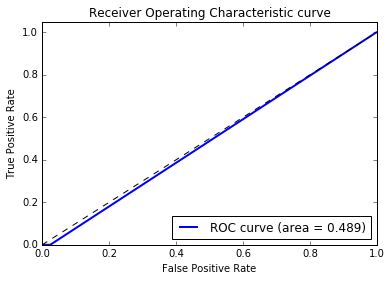

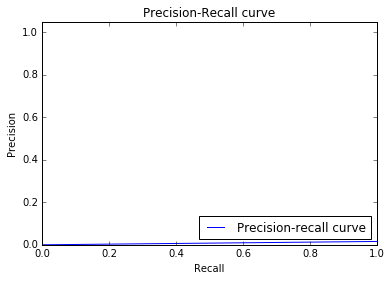

('\n', 'AdaBoost 10 trees', '\ntest size is 40 %  ')
0.994694960212
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.995
('The confusion matrix on the testing set:          \n',      0  1
0  750  3
1    1  0)
*********** AUC for ROC = 0.666


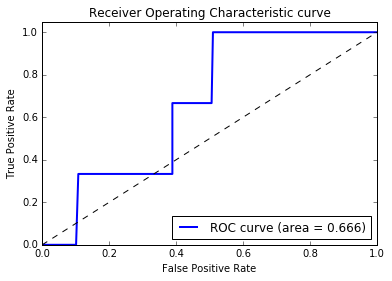

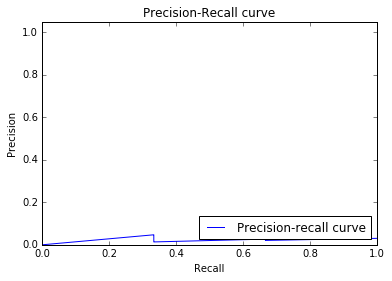

('\n', 'AdaBoost 40 trees', '\ntest size is 40 %  ')
0.994694960212
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.995
('The confusion matrix on the testing set:          \n',      0  1
0  750  3
1    1  0)
*********** AUC for ROC = 0.825


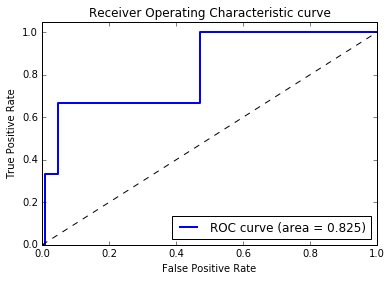

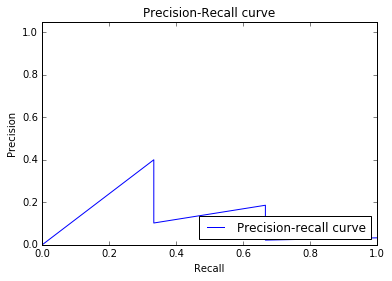

In [17]:
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

#### compare trees

train time: 2.265s
test time:  0.070s
0.996021220159


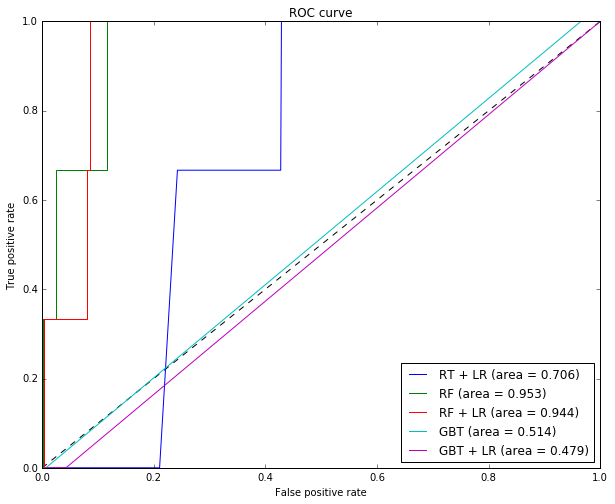

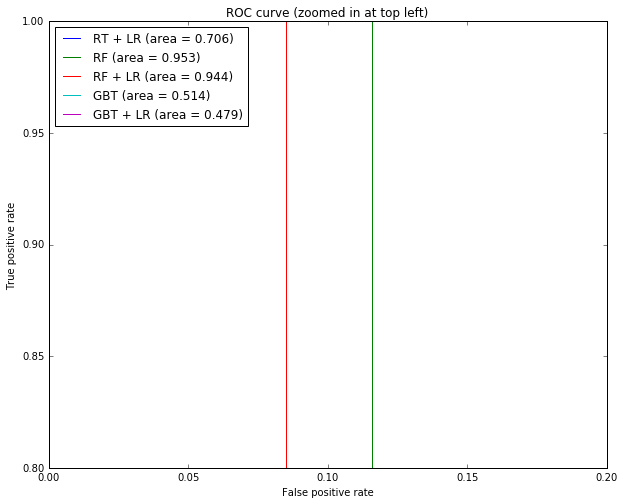

In [18]:
# plot comparable ROC curves for various tree-based classifiers 
# From SciKit Learn example 
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html

def compare_trees(X_train, X_test, y_train, y_test):
    """
    X_train - training set data features
    X_test - validation set data features
    y_train - training set data labels
    y_test - validation set truth
    
    compare_trees: function to run combo tree-based classifiers with Logistic Regresion
    and to plot comparable ROC curves for them
    yields: plots of the ROC curves and AUC scores
    
    """
        
    n_estimator = 40
    # It is important to train the ensemble of trees on a different subset
    # of the training data than the linear regression model to avoid
    # overfitting, in particular if the total number of leaves is
    # similar to the number of training samples
    X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)
    
    sw = weight(y_train)

    # Unsupervised transformation based on totally random trees
    rt = RandomTreesEmbedding(n_estimators=40, max_depth=1, random_state=RANDOM_STATE)

    rt_lm = LogisticRegression()
    pipeline = make_pipeline(rt, rt_lm)
    pipeline.fit(X_train, y_train)
    y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
    fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

    # Supervised transformation based on random forests
    rf = RandomForestClassifier(max_depth=3, n_estimators=200, random_state=RANDOM_STATE, class_weight = 'balanced')
    rf_enc = OneHotEncoder()
    rf_lm = LogisticRegression()
    rf.fit(X_train, y_train)
    rf_enc.fit(rf.apply(X_train))
    rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

    y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
    fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

    grd = GradientBoostingClassifier(n_estimators=40, learning_rate=1.0, max_depth=1, random_state=RANDOM_STATE)
    grd_enc = OneHotEncoder()
    grd_lm = LogisticRegression()
    grd.fit(X_train, y_train, sample_weight = sw)
    grd_enc.fit(grd.apply(X_train)[:, :, 0])
    grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

    y_pred_grd_lm = grd_lm.predict_proba(
        grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
    fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

    # The gradient boosted model by itself
    y_pred_grd = grd.predict_proba(X_test)[:, 1]
    fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

    # The random forest model by itself
    y_pred_rf = rf.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

    plt.figure(1)
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR (area = {0:0.3f})'
                       ''.format(auc(fpr_rt_lm, tpr_rt_lm)))
    plt.plot(fpr_rf, tpr_rf, label='RF (area = {0:0.3f})'
                       ''.format(auc(fpr_rf, tpr_rf)))
    plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR (area = {0:0.3f})'
                       ''.format(auc(fpr_rf_lm, tpr_rf_lm)))
    plt.plot(fpr_grd, tpr_grd, label='GBT (area = {0:0.3f})'
                       ''.format(auc(fpr_grd, tpr_grd)))
    plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR (area = {0:0.3f})'
                       ''.format(auc(fpr_grd_lm, tpr_grd_lm)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    plt.figure(2)
    plt.figure(figsize=(10,8))
    plt.xlim(0, 0.2)
    plt.ylim(0.8, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR (area = {0:0.3f})'
                       ''.format(auc(fpr_rt_lm, tpr_rt_lm)))
    plt.plot(fpr_rf, tpr_rf, label='RF (area = {0:0.3f})'
                       ''.format(auc(fpr_rf, tpr_rf)))
    plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR (area = {0:0.3f})'
                       ''.format(auc(fpr_rf_lm, tpr_rf_lm)))
    plt.plot(fpr_grd, tpr_grd, label='GBT (area = {0:0.3f})'
                       ''.format(auc(fpr_grd, tpr_grd)))
    plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR (area = {0:0.3f})'
                       ''.format(auc(fpr_grd_lm, tpr_grd_lm)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.show()
    

X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, random_state=RANDOM_STATE)

t0 = time()
clf = RandomForestClassifier(n_estimators=200, max_features='auto', random_state=RANDOM_STATE, class_weight = 'balanced')
clf.fit(X_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

t0 = time()
pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

score = metrics.accuracy_score(y_test, pred)
print (score)

compare_trees(X_train, X_test, y_train, y_test)

####  Clustering of word vectors - Bag of Centroids Setup

In [19]:
from sklearn.cluster import KMeans

start = time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.syn0
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict( word_vectors )

# Get the end time and print how long the process took
end = time()
elapsed = end - start
print ("Time taken for K Means clustering: ", elapsed, "seconds.")

('Time taken for K Means clustering: ', 171.87199997901917, 'seconds.')


In [20]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.index2word, idx ))

In [21]:
# For the first 10 clusters
for cluster in range(10):
    print ("\nCluster %d" % cluster)
    words = []
    [words.append(key) for  key, value in word_centroid_map.items() if value == cluster]
    print (words)


Cluster 0
['trinitrate', 'nh', 'arteriolar', 'glyceryl', 'renography', 'isradipinetherapeutic']

Cluster 1
['bronchial', 'inducedpathology', 'histamine', 'edemachemically', 'angioneurotic']

Cluster 2
['expectancy', 'microscopy', 'vaginal', 'satisfaction', 'consumptiondrug', 'mood', 'computerassisted', 'vital', 'mechanical']

Cluster 3
['ena', 'hbp']

Cluster 4
['possibly', 'remain', 'lifethreatening', 'occur', 'hyperkalemia']

Cluster 5
['simultaneously', 'substance', 'inhibited', 'metabolite', 'ec', 'reflex', 'thromboxane', 'enhancement', 'substrate', 'alleles', 'ramiprilat', 'degradation', 'eliminated', 'rapid']

Cluster 6
['initial', 'same']

Cluster 7
['march', 'centres', 'criteria', 'sample', 'analyzed', 'characteristics', 'inclusion', 'centers', 'prospectively', 'examination', 'screened']

Cluster 8
['nephropathiesprevention', 'doxazosintherapeutic', 'diseasesprevention', 'diseasesetiologyprevention', 'accidentprevention', 'diseaseprevention', 'therapyprevention']

Cluster 9
['

In [22]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    #
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # Loop over the words in the article. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

In [23]:
# Pre-allocate an array for the training set bags of centroids (for speed)
word_centroids = np.zeros( (inhibitor.TIABSMh.size, num_clusters), dtype="float32" )

# Transform the training set reviews into bags of centroids
counter = 0
for article in cleaned_articles:
    word_centroids[counter] = create_bag_of_centroids(article, word_centroid_map )
    counter += 1

Training and test datasets created
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=55, solver='lsqr', tol=0.01)
train time: 0.052s
test time:  0.003s
accuracy:   0.982
precision:  0.400
recall:     0.333
*** AUC for ROC = 0.986

classification report:
             precision    recall  f1-score   support

class Right       0.99      0.99      0.99     751.0
 class Left       0.40      0.33      0.36      12.0

avg / total       0.98      0.98      0.98     763.0

confusion matrix:
[[745   6]
 [  2   1]]
()
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=1, n_jobs=1, penalty=None,
      random_state=55, shuffle=True, verbose=0, warm_start=

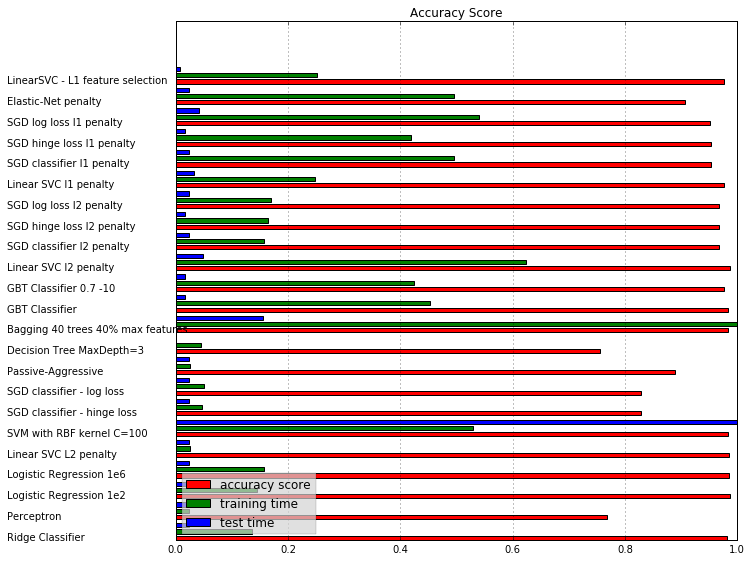

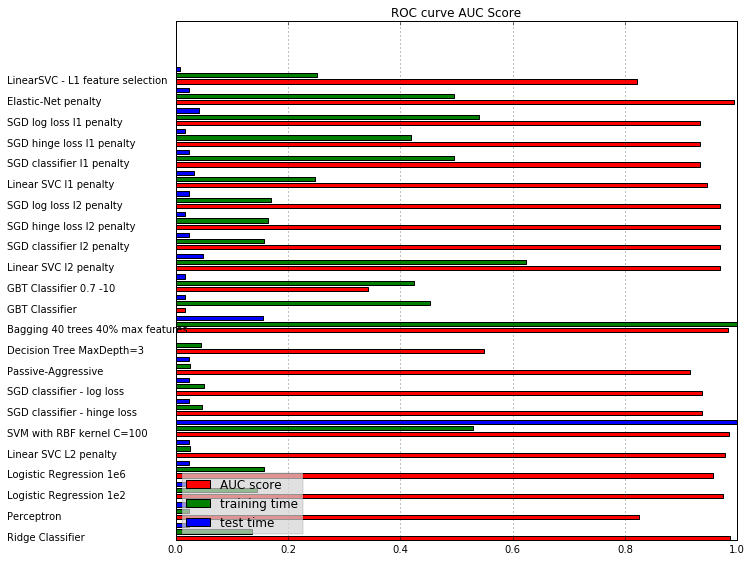

In [24]:
# options
print_report = True
print_cm = True

###############################################################################
# Load some categories from the training set

RANDOM_STATE = 55
TEST_SIZE = 0.4

X_train, X_test, y_train, y_test = train_test_split(word_centroids, inhibitor.Label, test_size=TEST_SIZE, random_state=RANDOM_STATE)
categories = ['class Right', 'class Left']
print('Training and test datasets created')

comparison_plots(create_results())